# Decision tree
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st
from itertools import combinations

In [ ]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log('amlrealworld.timeseries.dtree','true')

In [3]:
model_name = "dtree"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Using randomised search to find optimal hyperparameters

In [4]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [5]:
regr = DecisionTreeRegressor()
tscv = TimeSeriesSplit(n_splits=3)

In [6]:
param_dist = {'max_depth': st.randint(2, 20),
              'min_samples_split': st.randint(2, 50),
              'min_samples_leaf': st.randint(1, 100),
              'max_features': range(3,X.shape[1]+1)
             }
regr_cv = RandomizedSearchCV(estimator=regr,
            param_distributions=param_dist,
            n_iter=100,
            cv=tscv,
            iid=False,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_jobs=-1)
regr_pipe = Pipeline([('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.5s finished


Pipeline(steps=[('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
     ...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [7]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [8]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
88,0.343171,0.004163,-8964.171336,-1449.586625,16,11,3,6,"{'min_samples_split': 6, 'max_depth': 16, 'min...",1,-11745.337203,-1643.180264,-7996.386654,-1516.050132,-7150.790150,-1189.529480,0.166765,0.000230,1996.650704,191.072075
87,0.367833,0.004001,-9070.246470,-5444.549928,14,16,5,41,"{'min_samples_split': 41, 'max_depth': 14, 'mi...",2,-12916.810619,-7295.199744,-7174.310586,-5025.412792,-7119.618205,-4013.037248,0.177879,0.000816,2720.023239,1372.322755
9,0.304000,0.003334,-9583.629951,-6581.774194,13,13,13,42,"{'min_samples_split': 42, 'max_depth': 13, 'mi...",3,-13367.879593,-8525.966806,-7702.494223,-6008.362953,-7680.516035,-5210.992823,0.148210,0.000236,2675.883627,1412.766427
28,0.404833,0.004168,-10109.501660,-7248.548612,18,17,21,47,"{'min_samples_split': 47, 'max_depth': 18, 'mi...",4,-14629.733385,-9861.121647,-8151.957751,-6607.562224,-7546.813843,-5276.961965,0.191656,0.000624,3205.819804,1925.578296
47,0.323332,0.012167,-11576.964071,-8870.098007,9,15,14,2,"{'min_samples_split': 2, 'max_depth': 9, 'min_...",5,-13345.086367,-9251.870475,-10366.249553,-8745.087842,-11019.556293,-8613.335705,0.131250,0.012964,1278.383032,275.260263


Inspect the pairwise distribution of cross validation scores. Darker shades of blue indicate superior performance while the red star represents the optimal solution found.

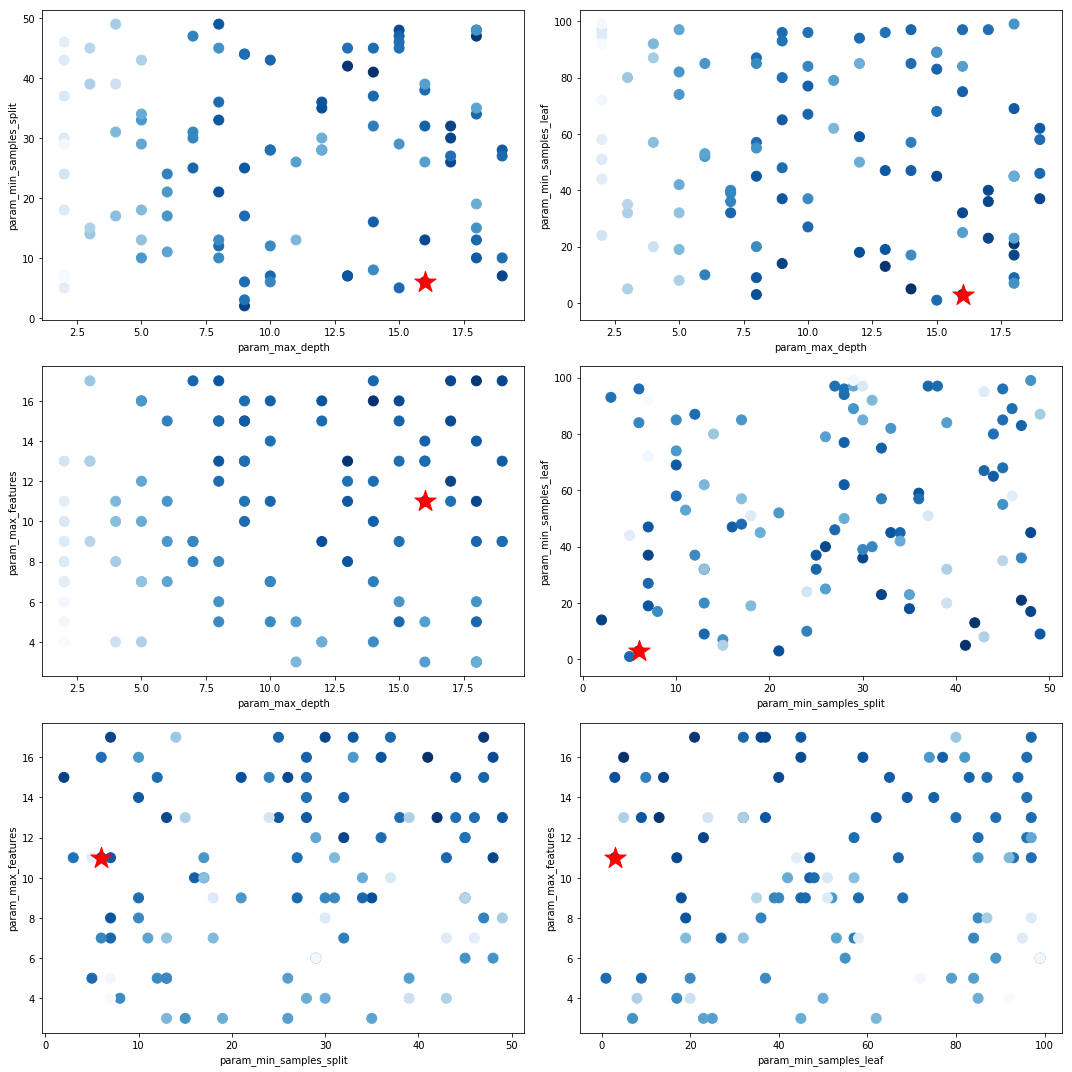

In [9]:
params = ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features']
gs = gridspec.GridSpec(3,2)
fig = plt.figure(figsize=(15, 15), tight_layout=True)
plt_best = cv_results.head(1)
for idx, params in enumerate(combinations(params, 2)):
    ax = fig.add_subplot(gs[idx])
    plt.scatter(cv_results[params[0]], cv_results[params[1]], c=-np.log(-cv_results['mean_test_score']), s=100, cmap="Blues")
    plt.scatter(plt_best[params[0]], plt_best[params[1]], s=500, marker="*", c="r")
    plt.xlabel(params[0])
    plt.ylabel(params[1])

Inspect feature importance

In [15]:
feature_importance.sort_values('importance', ascending=False)

,feature,importance
11,demand_lag1,0.881949
2,hour,0.087478
12,demand_lag2,0.018812
13,demand_lag3,0.002894
4,dayofweek,0.002039
10,temp_lag6,0.001849
15,demand_lag5,0.001752
14,demand_lag4,0.001036
16,demand_lag6,0.000630
5,temp_lag1,0.000572


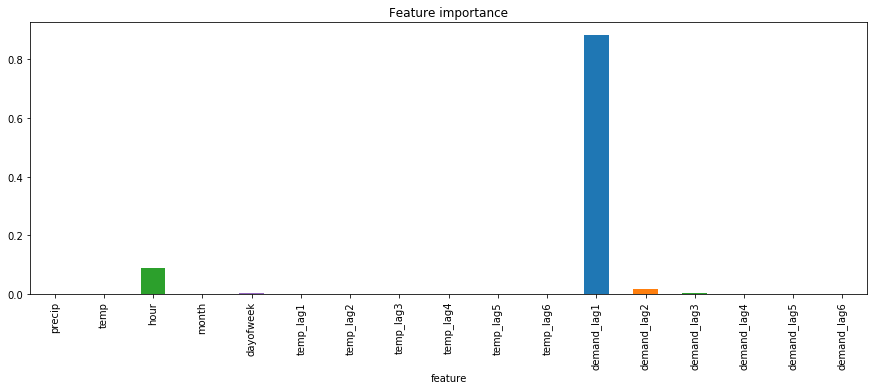

In [14]:
feature_importance = pd.DataFrame.from_dict({'feature':X.columns, 'importance':regr_pipe.named_steps['regr_cv'].best_estimator_.feature_importances_})
feature_importance.plot.bar('feature', 'importance', figsize=(15,5), title='Feature importance', legend=False)
plt.show()